In [118]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

dara_set_1 = datasets.load_iris()  
X_set1=dara_set_1.data
y_set1=dara_set_1.target

dara_set_2=datasets.load_breast_cancer()
X_set2=dara_set_2.data
y_set2=dara_set_2.target


x_train,x_test,y_train,y_test = train_test_split(X_set1,y_set1,test_size=0.33,random_state=0)
x_train_2,x_test_2,y_train_2,y_test_2 = train_test_split(X_set2,y_set2,test_size=0.33,random_state=0)



In [152]:
# encoding=utf-8
import math

from collections import defaultdict

from sklearn.metrics import accuracy_score


class MaxEnt(object):

    def init_params(self, X, Y,num_train=500):
        self.X_ = X 
        self.Y_ = set()
        self.num_train=num_train #训练轮数
        self.cal_Vxy(X, Y)  # 计算v(X=x,Y=y)

        self.N = len(X) # 训练集大小
        self.n = len(self.Vxy)  # 数据集中(x,y)对数
        self.lr= 0.0001 # 学习率
        self.build_dict() # 构建字典
        self.cal_Pxy() # 计算P(X=x,Y=y)

    def cal_Vxy(self, X, Y): # 计算v(X=x,Y=y)
        self.Vxy = defaultdict(int)  #字典映射

        for i in range(len(X)):
            x_, y = X[i], Y[i]
            self.Y_.add(y) 
            for x in x_:
                self.Vxy[(x, y)] += 1 

    def build_dict(self): # 构建字典--用于存储(x,y)对
        self.id2xy = {}
        self.xy2id = {}
        for i, (x, y) in enumerate(self.Vxy):
            self.id2xy[i] = (x, y)
            self.xy2id[(x, y)] = i

    def cal_Pxy(self): # 计算P(X=x,Y=y)
        self.Pxy = defaultdict(float)
        for id in range(self.n):
            (x, y) = self.id2xy[id]
            self.Pxy[id] = float(self.Vxy[(x, y)]) / float(self.N) #计算P(X=x,Y=y)


    def cal_Zx(self, X, y):
        '''
        计算Zw(x/yi)，根据P85公式6.23，Zw(x)未相加前的单项
        '''
        result = 0.0
        for x in X:
            if (x,y) in self.xy2id:
                id = self.xy2id[(x, y)]
                result += self.w[id]
        return (math.exp(result), y)

    def cal_Pyx(self, X):
        '''
        计算P(y|x),根据P85公式6.22
        '''
        Pyxs = [(self.cal_Zx(X, y)) for y in self.Y_]
        Zwx = sum([prob for prob, y in Pyxs])
        return [(prob / Zwx, y) for prob, y in Pyxs]

    def cal_Epfi(self):
        '''
        计算Ep(fi),根据P83最上面的公式
        '''
        self.Epfi = [0.0 for i in range(self.n)]

        for i, X in enumerate(self.X_):
            Pyxs = self.cal_Pyx(X)

            for x in X:
                for Pyx, y in Pyxs:
                    if (x,y) in self.xy2id:
                        id = self.xy2id[(x, y)]

                        self.Epfi[id] += Pyx * (1.0 / self.N)


    def train(self, X, Y,test_x,test_y):

        self.init_params(X, Y) # 初始化参数
        self.w = [0.0 for i in range(self.n)] # 初始化w--0
        max_iteration = self.num_train  # 最大迭代次数
        for times in range(max_iteration):
            if times%100==0: #每100轮输出一次
                _p=self.predict(test_x)
                acc=accuracy_score(test_y,_p)
                print(f"目前训练轮数是 : {times} | 正确率是 :{acc}")
            # 第二步：求δi
            detas = []
            self.cal_Epfi()
            for i in range(self.n):
                deta = self.lr * math.log(self.Pxy[i] / self.Epfi[i])  # 指定的特征函数为指示函数，因此E~p(fi)等于Pxy
                detas.append(deta)
            self.w = [self.w[i] + detas[i] for i in range(self.n)] # 更新w

    def predict(self, testset):
        results = []
        for test in testset:
            result = self.cal_Pyx(test)
            results.append(max(result, key=lambda x: x[0])[1])
        return results


def rebuild_features(features):
    '''
    最大熵模型中的f(x,y)中的x是单独的一个特征,不是一个n维特征向量，因此我们需要对每个维度特征加一个区分标签 
    具体地：将原feature的（a0,a1,a2,a3,a4,...） 变成 (0_a0,1_a1,2_a2,3_a3,4_a4,...)形式
    '''
    new_features = []
    for feature in features:
        new_feature = []
        for i, f in enumerate(feature):
            new_feature.append(str(i) + '_' + str(f))
        new_features.append(new_feature)
    return new_features

In [159]:
x_train.shape #(100, 4)

(100, 4)

In [149]:
train_features = rebuild_features(x_train)
train_features_2 = rebuild_features(x_train_2)

test_features = rebuild_features(x_test)
test_features_2 = rebuild_features(x_test_2)

In [153]:
met = MaxEnt()
met.train(train_features, y_train,test_features,y_test)
test_predict = met.predict(test_features)
score = accuracy_score(y_test, test_predict)
score 

目前训练轮数是 : 0 | 正确率是 :0.32
目前训练轮数是 : 100 | 正确率是 :0.92
目前训练轮数是 : 200 | 正确率是 :0.92
目前训练轮数是 : 300 | 正确率是 :0.92
目前训练轮数是 : 400 | 正确率是 :0.92


0.92

In [154]:
met = MaxEnt()
met.train(train_features_2, y_train_2,test_features_2,y_test_2)
test_predict = met.predict(test_features_2)
score = accuracy_score(y_test_2, test_predict)
score 

目前训练轮数是 : 0 | 正确率是 :0.35638297872340424
目前训练轮数是 : 100 | 正确率是 :0.7127659574468085
目前训练轮数是 : 200 | 正确率是 :0.7127659574468085
目前训练轮数是 : 300 | 正确率是 :0.7127659574468085
目前训练轮数是 : 400 | 正确率是 :0.7127659574468085


0.7127659574468085

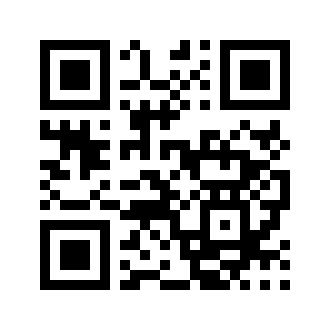

In [171]:
#无关的东西
import qrcode
from qrcode.util import *

def hack_put(self, num, length):
    if num == 0:
        num = 233 # make a fake length
    for i in range(length):
        self.put_bit(((num >> (length - i - 1)) & 1) == 1)

qrcode.util.BitBuffer.put = hack_put

qr = qrcode.QRCode(2, qrcode.constants.ERROR_CORRECT_M, mask_pattern=0)

num_data = QRData('1145141', MODE_NUMBER)
data = QRData(b'.', MODE_8BIT_BYTE)
hack_data = QRData(b'', MODE_8BIT_BYTE)

# make sure all data is fit to the max content length for this version
qr.add_data(num_data)
qr.add_data(data)
qr.add_data(num_data)
qr.add_data(data)
qr.add_data(num_data)
qr.add_data(data)
qr.add_data(num_data)
# add a zero length data to make the length of the data to be 233
qr.add_data(hack_data)

qr.make_image()
